### Install and Import Packages

In [1]:
! pip install pandas
! pip install Image
! pip install matplotlib
! pip install numpy
! pip install scikit-image
! pip install mahotas
! pip install scikit-learn
! pip install opencv-python
! pip install seaborn
! pip install tensorflow
! pip install keras
! pip install torch torchvision efficientnet_pytorch


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16464 sha256=dfeb573335b8f07fc4d62dad68a1c96a95cb568d464435c702320e9bdf806c8b
  Stored in directory: c:\users\junio\appdata\local\pip\cache\wheels\8b\6f\9b\231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
Successfully built efficientnet_pytorch


In [30]:
import os, copy
import cv2
import pickle
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from PIL import Image
import matplotlib.pylab as plt
import mahotas as mh
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform, loguniform
import seaborn as sns
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.applications import EfficientNetB0
from keras._tf_keras.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support

### Global Variables - Paths

In [3]:
CSV_PATH = 'classifications.csv'
IMAGE_SET_PATH = 'dataset'
CLASSES_PATH = 'classes'

### Functions

In [4]:
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#### Loading and Filtering Data

In [5]:
def filter_existing_images(data):
    existing_imgs = []
    missing_img = []

    for index, row in data.iterrows():
        
        image_path = os.path.join(IMAGE_SET_PATH, row['image_filename'])
        if os.path.isfile(image_path):
            existing_imgs.append(index)
        else:
            missing_img.append(row['image_filename'])

    #if missing_img:
    #    print(f"Missing files: {len(missing_img)}")
    #    print(missing_img)

    filtered_data = data.loc[existing_imgs]
    filtered_data['bethesda_system'] = filtered_data['bethesda_system'].replace('Negative for intraepithelial lesion', 'Negative_for_intraepithelial_lesion')
    return filtered_data

#### Cropping and Saving Images

In [6]:
def make_class_dir (classes):
    for class_name in classes:
        os.makedirs(os.path.join(CLASSES_PATH, class_name), exist_ok=True)

In [7]:
def get_crop_box (x, y, width, height, crop_size = 100):
    half_crop = crop_size // 2
    left = max(0, x - half_crop)
    upper = max(0, y - half_crop)
    right = min(width, x + half_crop)
    lower = min(height, y + half_crop)

    if right - left < crop_size:
        if left == 0:
            right = left + crop_size
        else:
            left = right - crop_size
    if lower - upper < crop_size:
        if upper == 0:
            lower = upper + crop_size
        else:
            upper = lower - crop_size

    return (left, upper, right, lower)

#### Feature Extraction

In [6]:
def generate_grayscale_histogram(img, bins = 16):
    grayscale_image = img.convert("L")
    histogram, bin_edges = np.histogram(grayscale_image, bins=bins, range=(0,255))

    return histogram

In [7]:
def generate_hsv_histogram(img, h_bins=16, v_bins=8):
    hsv_img = img.convert("HSV")
    h, s, v = hsv_img.split()
    h = np.array(h) // (256 // h_bins)
    v = np.array(v) // (256 // v_bins)
    histogram, _, _ = np.histogram2d(h.flatten(), v.flatten(), bins=[h_bins, v_bins], range=[[0, h_bins], [0, v_bins]])
    return histogram

In [8]:
def quantize_image(image, levels = 16):
    grayscale_image = image.convert("L")
    quantized_image = np.array(grayscale_image) // (256 // levels)
    return quantized_image

In [9]:
def compute_cooccurrence_matrices(q_img, distances=[1, 2, 4, 8, 16, 32], angles=[0]):
    cooccurrence_matrices = graycomatrix(q_img, distances, angles, levels=16, symmetric=True, normed=True)
    return cooccurrence_matrices


In [11]:
def compute_glcm(q_img, dists=[1, 2 ,4, 8, 16, 32], angles=[0]):
    glcm = graycomatrix(q_img, distances=dists, angles=angles, levels=16, symmetric=True, normed=True)
    return glcm

In [10]:
def compute_haralick_features(glcm):
    contrast = graycoprops(glcm, 'contrast').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    
    # Entropy calculation
    glcm_sum = glcm.sum(axis=(0, 1))
    norm_glcm = glcm / glcm_sum
    entropy = -np.sum(norm_glcm * np.log(norm_glcm + 1e-10), axis=(0, 1)).flatten()
    
    features = {
        'contrast': contrast,
        'homogeneity': homogeneity,
        'entropy': entropy
    }
    return features

In [12]:
def load_data(classes, image_size=(100, 100)):
    images = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(CLASSES_PATH, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.png'):
                img_path = os.path.join(class_dir, filename)
                img = Image.open(img_path).resize(image_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(class_name)
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [13]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Main

#### Loading and Filtering Data

In [14]:
brute_data = pd.read_csv(CSV_PATH)
table_data = filter_existing_images(brute_data)

##### Dataset

#### Cropping and Saving Images

In [20]:
## NAO PRECISA RODAR
make_class_dir(table_data['bethesda_system'].unique())

for index, row in table_data.iterrows():
    image_path = os.path.join(IMAGE_SET_PATH, row['image_filename'])
    x, y = int(row['nucleus_x']), int(row['nucleus_y'])
    class_name = row['bethesda_system']
    cell_id = row['cell_id']

    with Image.open(image_path) as img:
        width, height = img.size
        crop_box = get_crop_box(x, y, width, height)
        cropped_img = img.crop(crop_box)

        output_path = os.path.join(CLASSES_PATH, class_name, f'{cell_id}.png')
        cropped_img.save(output_path)

#### Feature Extraction

In [15]:
table_data.head(5)

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
526,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,527,LSIL,998,890
527,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,528,LSIL,645,600
528,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,529,LSIL,609,585
529,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,530,Negative_for_intraepithelial_lesion,393,140
530,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,531,Negative_for_intraepithelial_lesion,348,207


In [16]:
img_data = []

for index, row in table_data.iterrows():
    cell_id = row['cell_id']
    img_path = os.path.join(CLASSES_PATH, row['bethesda_system'], f"{row['cell_id']}.png")
    img_class = row['bethesda_system']

    image = Image.open(img_path)

    if image is not None:
        q_img = quantize_image(image)
        glcm = compute_glcm(q_img)
        haralick_features = compute_haralick_features(glcm)

        img_data.append ({
            'cell_id': cell_id,
            'image_path': img_path,
            'contrast_1': haralick_features['contrast'][0],
            'contrast_2': haralick_features['contrast'][1],
            'contrast_4': haralick_features['contrast'][2],
            'contrast_8': haralick_features['contrast'][3],
            'contrast_16': haralick_features['contrast'][4],
            'contrast_32': haralick_features['contrast'][5],
            'homogeneity_1': haralick_features['homogeneity'][0],
            'homogeneity_2': haralick_features['homogeneity'][1],
            'homogeneity_4': haralick_features['homogeneity'][2],
            'homogeneity_8': haralick_features['homogeneity'][3],
            'homogeneity_16': haralick_features['homogeneity'][4],
            'homogeneity_32': haralick_features['homogeneity'][5],
            'entropy_1': haralick_features['entropy'][0],
            'entropy_2': haralick_features['entropy'][1],
            'entropy_4': haralick_features['entropy'][2],
            'entropy_8': haralick_features['entropy'][3],
            'entropy_16': haralick_features['entropy'][4],
            'entropy_32': haralick_features['entropy'][5],
            'img_class': img_class
        })
        
dataset = pd.DataFrame(img_data)


In [20]:
dataset

,cell_id,image_path,contrast_1,contrast_2,contrast_4,contrast_8,contrast_16,contrast_32,homogeneity_1,homogeneity_2,...,homogeneity_8,homogeneity_16,homogeneity_32,entropy_1,entropy_2,entropy_4,entropy_8,entropy_16,entropy_32,img_class
0,527,classes\LSIL\527.png,0.191313,0.412755,0.694687,0.834457,1.057976,1.480441,0.912707,0.854761,...,0.780637,0.731606,0.648846,1.665656,1.882955,2.016678,2.075661,2.131085,2.174239,LSIL
1,528,classes\LSIL\528.png,0.428586,1.153061,2.904479,5.091087,8.729524,12.303824,0.842099,0.732686,...,0.555353,0.443094,0.294571,3.056068,3.424695,3.727101,3.914227,4.137028,4.262553,LSIL
2,529,classes\LSIL\529.png,0.466970,1.277143,3.318646,6.004130,9.172738,13.866618,0.833210,0.715350,...,0.500122,0.400853,0.298044,3.305461,3.692300,4.032625,4.235667,4.404555,4.546074,LSIL
3,530,classes\Negative_for_intraepithelial_lesion\53...,0.450808,1.172245,3.026250,6.138696,10.495238,12.328529,0.815387,0.686825,...,0.503170,0.453684,0.415722,2.951271,3.337305,3.654085,3.804699,3.842743,3.802849,Negative_for_intraepithelial_lesion
4,531,classes\Negative_for_intraepithelial_lesion\53...,0.553333,1.499388,3.699792,6.790217,11.197619,10.926765,0.793325,0.659641,...,0.466280,0.399274,0.332736,3.181807,3.605960,3.933173,4.090363,4.195630,4.145501,Negative_for_intraepithelial_lesion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5576,11488,classes\ASC-US\11488.png,0.265253,0.474490,0.836979,1.550217,3.148333,6.477353,0.874162,0.801643,...,0.616137,0.473467,0.323567,2.657588,2.899232,3.151983,3.412513,3.635199,3.743565,ASC-US
5577,11489,classes\ASC-US\11489.png,0.265960,0.474388,0.866563,1.791957,3.622976,4.541029,0.871505,0.796408,...,0.612056,0.485398,0.417417,2.561708,2.818730,3.079641,3.357992,3.546509,3.472974,ASC-US
5578,11490,classes\ASC-US\11490.png,0.265455,0.464184,0.817188,1.618478,3.135000,4.289265,0.872242,0.799673,...,0.622472,0.507987,0.415810,2.463039,2.707001,2.947987,3.196990,3.362863,3.366448,ASC-US
5579,11491,classes\ASC-US\11491.png,0.295152,0.548980,0.982917,1.845978,3.807024,6.136618,0.864046,0.786086,...,0.625565,0.505148,0.400911,2.559424,2.820298,3.062703,3.282401,3.483344,3.465089,ASC-US


In [17]:
features = dataset.drop(columns=['cell_id', 'image_path', 'img_class'])
labels = dataset['img_class']

#### Binary SVM Classifier

In [22]:
binary_labels = np.array(['Negative' if label == 'Negative_for_intraepithelial_lesion' else 'Positive' for label in labels])

X_train, X_test, y_train, y_test = train_test_split(features, binary_labels, test_size=0.2, stratify=binary_labels, random_state=49)

# Step 1: Undersample the predominant class
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Apply SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=49, k_neighbors=5, sampling_strategy='not majority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_res, y_res)


In [43]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 'scale'],
    'kernel': ['linear', 'rbf']
}

# Create a base model
svc = SVC(class_weight='balanced', random_state=49)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = grid_search.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [44]:
print(f"Best parameters found: {best_params}")

Best parameters found: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [45]:
binary_svm_classifier = SVC(**best_params, class_weight='balanced', random_state=49)
binary_svm_classifier.fit(X_train_resampled, y_train_resampled)

y_pred = binary_svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, zero_division=0))

print("Binary SVC Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

              precision    recall  f1-score   support

    Negative       0.83      0.80      0.82       849
    Positive       0.44      0.49      0.46       268

    accuracy                           0.73      1117
   macro avg       0.64      0.64      0.64      1117
weighted avg       0.74      0.73      0.73      1117

Binary SVC Accuracy: 0.7278424350940018
Confusion Matrix:
 [[683 166]
 [138 130]]


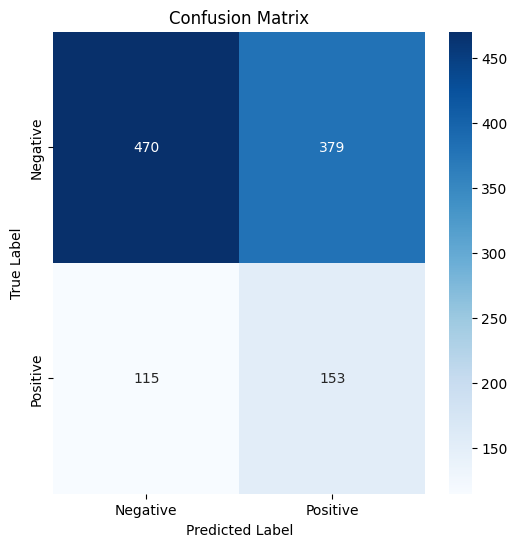

In [41]:
plot_confusion_matrix(conf_matrix, classes=['Negative', 'Positive'])

##### Saving the Binary SVM Classifier Model

In [46]:
model_filename = 'binary_svm_classifier.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(binary_svm_classifier, file)

# Load the model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully")

# Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
print("Loaded Model Accuracy:", accuracy_loaded)

Model loaded successfully
Loaded Model Accuracy: 0.7278424350940018


#### Multiclass SVM Classifier

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=49)

# Step 1: Undersample the predominant class
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Apply SMOTE to generate synthetic samples for the minority class
smote = SMOTE(random_state=49, k_neighbors=5, sampling_strategy='not majority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_res, y_res)


In [54]:
param_distributions = {
    'C': loguniform(1e-3, 1e3),
    'gamma': loguniform(1e-6, 1e-1),
    'kernel': ['linear', 'rbf', 'sigmoid']
}

# Create a base model
svc = SVC(class_weight='balanced', random_state=49)

# Instantiate the randomized search model
random_search = RandomizedSearchCV(estimator=svc, param_distributions=param_distributions, n_iter=100, cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=49)

# Time the randomized search
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = random_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [55]:
print(f"Best parameters found: {best_params}")

Best parameters found: {'C': 240.3824094525685, 'gamma': 0.002092596563459998, 'kernel': 'linear'}


In [56]:
multiclass_svm_classifier = SVC(**best_params, class_weight='balanced', random_state=49)
#multiclass_svm_classifier = SVC(C=1.0, kernel='linear', gamma='scale', class_weight='balanced', random_state=49)
multiclass_svm_classifier.fit(X_train_resampled, y_train_resampled)

y_pred = multiclass_svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, zero_division=0))

print("Multi-Class SVM Accuracy:", accuracy)
print("Multi-Class SVM Confusion Matrix:\n", conf_matrix)

                                     precision    recall  f1-score   support

                              ASC-H       0.02      0.24      0.04        17
                             ASC-US       0.10      0.36      0.16        78
                               HSIL       0.21      0.33      0.26        58
                               LSIL       0.20      0.29      0.24        99
Negative_for_intraepithelial_lesion       0.86      0.39      0.54       849
                                SCC       0.14      0.50      0.21        16

                           accuracy                           0.38      1117
                          macro avg       0.26      0.35      0.24      1117
                       weighted avg       0.69      0.38      0.46      1117

Multi-Class SVM Accuracy: 0.37600716204118173
Multi-Class SVM Confusion Matrix:
 [[  4   4   6   0   3   0]
 [  8  28   4  15  21   2]
 [ 11   1  19   2   8  17]
 [ 16  21   6  29  23   4]
 [124 220  49  96 332  28]
 [  1   1  

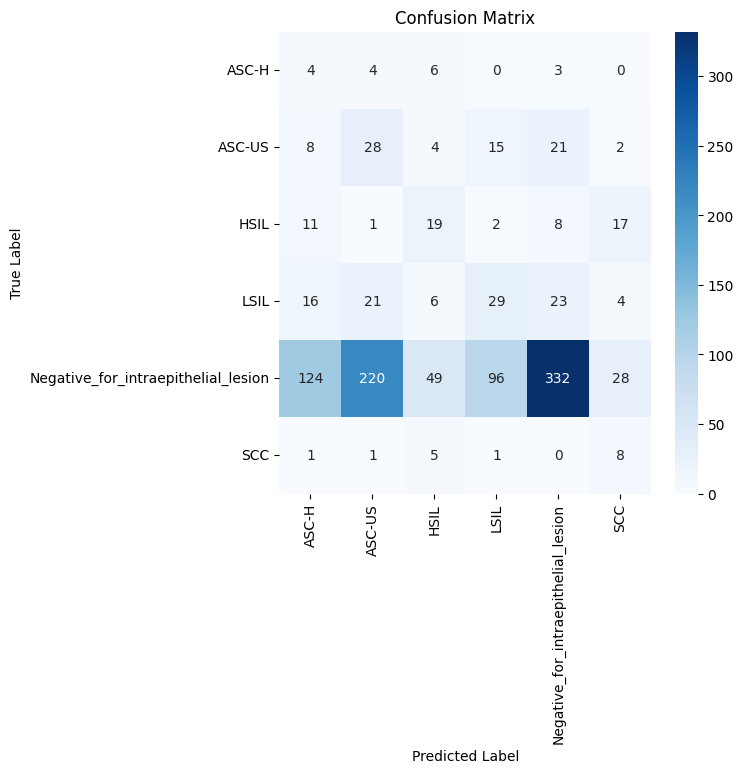

In [57]:
plot_confusion_matrix(conf_matrix, classes=['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative_for_intraepithelial_lesion', 'SCC'])

##### Saving the Multiclass SVM Model

In [58]:
model_filename = 'multiclass_svm_classifier.pkl'

with open(model_filename, 'wb') as file:
    pickle.dump(multiclass_svm_classifier, file)

# Load the model
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully")

# Use the loaded model to make predictions
y_pred_loaded = loaded_model.predict(X_test)
accuracy_loaded = accuracy_score(y_test, y_pred_loaded)
print("Loaded Model Accuracy:", accuracy_loaded)

Model loaded successfully
Loaded Model Accuracy: 0.37600716204118173


#### Binary EfficientNet Novo

In [23]:
df = dataset.copy()

df['binary_class'] = df['img_class'].apply(lambda x: 'Negative' if x == 'Negative_for_intraepithelial_lesion' else 'Positive')

train_dir_path = 'train_imgs'
test_dir_path = 'test_imgs'

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['img_class'], random_state=49)



In [24]:
for index, row in train_df.iterrows():
        cell_id = row['cell_id']
        train_class_dir = os.path.join(train_dir_path, row['binary_class'])
        if not os.path.exists(train_class_dir):
            os.makedirs(train_class_dir)
        src_path = row['image_path']
        dst_path = os.path.join(train_class_dir, f'{cell_id}.png')
        shutil.copy(src_path, dst_path)

for index, row in test_df.iterrows():
        cell_id = row['cell_id']
        test_class_dir = os.path.join(test_dir_path, row['binary_class'])
        if not os.path.exists(test_class_dir):
            os.makedirs(test_class_dir)
        src_path = row['image_path']
        dst_path = os.path.join(test_class_dir, f'{cell_id}.png')
        shutil.copy(src_path, dst_path)


In [51]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

In [60]:
# Criando os geradores
train_generator = train_datagen.flow_from_directory(
    train_dir_path,
    follow_links=True,
    
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir_path,
    follow_links=True,
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir_path,
    follow_links=True,
    target_size=(100, 100),
    batch_size=32,
    class_mode='binary')

Found 3572 images belonging to 2 classes.
Found 892 images belonging to 2 classes.
Found 1117 images belonging to 2 classes.


In [61]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Congelar as camadas base
base_model.trainable = False

# Adicionar camadas de classificação
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Definir o modelo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinar o modelo
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator
)

Epoch 1/5


c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


112/112 ━━━━━━━━━━━━━━━━━━━━ 76s 576ms/step - accuracy: 0.7461 - loss: 0.0000e+00 - val_accuracy: 0.7612 - val_loss: 0.0000e+00
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 35s 303ms/step - accuracy: 0.7669 - loss: 0.0000e+00 - val_accuracy: 0.7612 - val_loss: 0.0000e+00
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 35s 307ms/step - accuracy: 0.7528 - loss: 0.0000e+00 - val_accuracy: 0.7612 - val_loss: 0.0000e+00
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 35s 308ms/step - accuracy: 0.7549 - loss: 0.0000e+00 - val_accuracy: 0.7612 - val_loss: 0.0000e+00
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 35s 307ms/step - accuracy: 0.7576 - loss: 0.0000e+00 - val_accuracy: 0.7612 - val_loss: 0.0000e+00


In [62]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 14s 399ms/step - accuracy: 0.7739 - loss: 0.0000e+00
Test accuracy: 0.7600716352462769


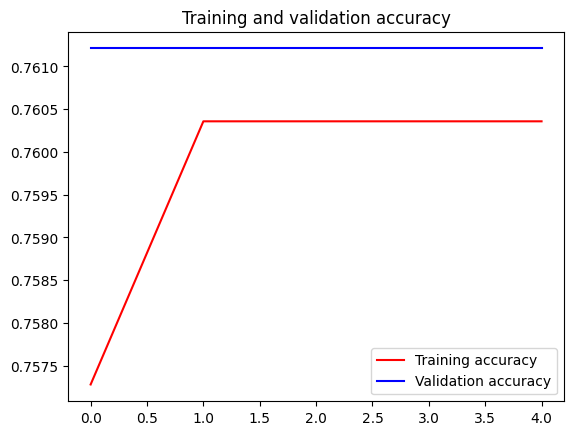

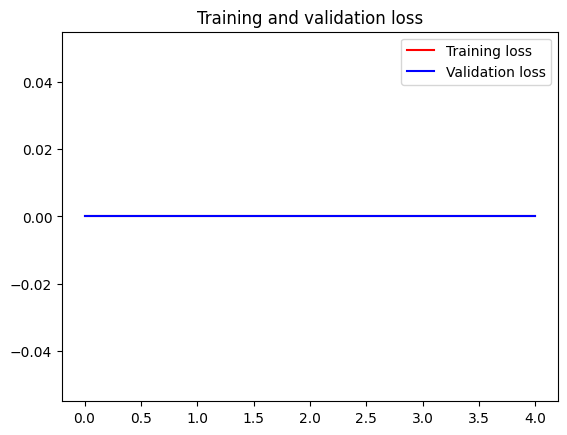

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [65]:
# Prever os rótulos do conjunto de teste
test_steps = test_generator.samples // test_generator.batch_size
predictions = model.predict(test_generator, steps=test_steps + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Obter rótulos verdadeiros
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calcular a matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_labels)

# Plotar a matriz de confusão
cmd.plot()
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 189ms/step
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       849
           1       0.00      0.00      0.00       268

    accuracy                           0.76      1117
   macro avg       0.38      0.50      0.43      1117
weighted avg       0.58      0.76      0.66      1117

Binary EfficientNet Accuracy: [0.7572788596153259, 0.7603583335876465, 0.7603583335876465, 0.7603583335876465, 0.7603583335876465]
Binary EfficientNet Confusion Matrix:
 [[849   0]
 [268   0]]


#### Binary EfficientNet Pytorch 

In [18]:
df = dataset.copy()

df['binary_class'] = df['img_class'].apply(lambda x: 'Negative' if x == 'Negative_for_intraepithelial_lesion' else 'Positive')


bin_data_dir = 'binary_effnet_data'

train_dir_path = 'train'
test_dir_path = 'test'

train_dir_path = os.path.join(bin_data_dir, train_dir_path)
test_dir_path = os.path.join(bin_data_dir, test_dir_path)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['img_class'], random_state=49)

In [19]:
for index, row in train_df.iterrows():
        cell_id = row['cell_id']
        train_class_dir = os.path.join(train_dir_path, row['binary_class'])
        if not os.path.exists(train_class_dir):
            os.makedirs(train_class_dir)
        src_path = row['image_path']
        dst_path = os.path.join(train_class_dir, f'{cell_id}.png')
        shutil.copy(src_path, dst_path)

for index, row in test_df.iterrows():
        cell_id = row['cell_id']
        test_class_dir = os.path.join(test_dir_path, row['binary_class'])
        if not os.path.exists(test_class_dir):
            os.makedirs(test_class_dir)
        src_path = row['image_path']
        dst_path = os.path.join(test_class_dir, f'{cell_id}.png')
        shutil.copy(src_path, dst_path)


In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),  # Redimensiona para 256x256 antes do recorte aleatório
        transforms.RandomResizedCrop(224),  # Recorta aleatoriamente para 224x224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),  # Redimensiona para 256x256 antes do recorte central
        transforms.CenterCrop(224),  # Recorta centralmente para 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [21]:

batch_size = 32
image_datasets = {x: datasets.ImageFolder(os.path.join(bin_data_dir, x),data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


In [22]:
train_labels = np.array([label for _, label in image_datasets['train'].imgs])

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Criação de um WeightedRandomSampler
class_sample_counts = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])
weights = 1. / class_sample_counts
samples_weights = weights[train_labels]

sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

# Atualizando o DataLoader de treino para usar o WeightedRandomSampler
train_loader = DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler, num_workers=4)
test_loader = dataloaders['test']
dataloaders['train'] = train_loader

In [39]:
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(next(model.parameters()).device)
print(torch.cuda.is_available())

cuda:0
True


d:\dev\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\dev\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Cada época possui uma fase de treino e uma de validação
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Configura o modelo para treinamento
            else:
                model.eval()   # Configura o modelo para avaliação

            running_loss = 0.0
            running_corrects = 0

            # Itera sobre os dados
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zera os gradientes dos parâmetros
                optimizer.zero_grad()

                # Forward
                # Track history se apenas na fase de treino
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + otimiza apenas na fase de treino
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estatísticas
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Profunda cópia do modelo
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:4f}')

    # Carrega os melhores pesos do modelo
    model.load_state_dict(best_model_wts)
    return model

In [46]:
model_ft = train_model(model, dataloaders, criterion, optimizer, num_epochs=100)

Epoch 0/99
----------
train Loss: 0.4995 Acc: 0.6080
test Loss: 0.6999 Acc: 0.4897

Epoch 1/99
----------
train Loss: 0.4383 Acc: 0.6624
test Loss: 0.6569 Acc: 0.5166

Epoch 2/99
----------
train Loss: 0.4120 Acc: 0.6808
test Loss: 0.6805 Acc: 0.5040

Epoch 3/99
----------
train Loss: 0.4104 Acc: 0.7027
test Loss: 0.7108 Acc: 0.5318

Epoch 4/99
----------


In [38]:
# Salva o modelo
path = 'Models/efficientNet_binario.pth'
index = 0
while os.path.exists(path):
    index += 1
    path = f'Models/efficientNet_cpu_bin_{index}.pth'
model_ft = model_ft.to(torch.device('cpu'))
torch.save(model_ft, path)

In [37]:
def evaluate_model(model, dataloaders):
    model.eval()  # Coloca o modelo em modo de avaliação
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Avalia o modelo no conjunto de teste
labels, preds = evaluate_model(model_ft, dataloaders)

# Calcula acurácia, precisão, recall e F1-score
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

# Imprime as métricas
print(f'Acurácia: {accuracy:.4f}')
print(f'Precisão: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

# Calcula a matriz de confusão
conf_matrix = confusion_matrix(labels, preds)

# Converte a matriz de confusão para um DataFrame para melhor visualização
df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Plota a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.title('Matriz de Confusão')
plt.show()

# Relatório de classificação detalhado
report = classification_report(labels, preds, target_names=class_names)
print(report)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

#### Binary EfficientNet Velho

In [61]:
df = table_data.copy()

df['bethesda_system'] = df['bethesda_system'].replace('Negative for intraepithelial lesion', 'Negative_for_intraepithelial_lesion')
df['image_path'] = df.apply(lambda row: os.path.join(CLASSES_PATH, row['bethesda_system'], f"{row['cell_id']}.png"), axis=1)
df['binary_class'] = df['bethesda_system'].apply(lambda x: 'Negative' if x == 'Negative_for_intraepithelial_lesion' else 'Positive')

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['binary_class'], random_state=49)

In [66]:
# Number of samples in the training and validation sets
num_train_samples = len(train_df)
num_val_samples = len(test_df)

epochs = 25

# Batch size
batch_size = 32

# Calculate steps per epoch and validation steps
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size


train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',  # Assuming the path to the cropped image is in the 'image_path' column
    y_col='binary_class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',  # Assuming the path to the cropped image is in the 'image_path' column
    y_col='binary_class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Load the EfficientNetB0 model with pre-trained ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
binary_efficientnet_classifier = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
binary_efficientnet_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = binary_efficientnet_classifier.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    #callbacks=[early_stopping],
    epochs=epochs 
)


Found 4464 validated image filenames belonging to 2 classes.
Found 1117 validated image filenames belonging to 2 classes.
Epoch 1/25


c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/139 ━━━━━━━━━━━━━━━━━━━━ 791s 5s/step - accuracy: 0.7473 - loss: 0.0000e+00 - val_accuracy: 0.7583 - val_loss: 0.0000e+00
Epoch 2/25
  1/139 ━━━━━━━━━━━━━━━━━━━━ 11:19 5s/step - accuracy: 0.6875 - loss: 0.0000e+00

c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6875 - loss: 0.0000e+00 - val_accuracy: 0.8276 - val_loss: 0.0000e+00
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 710s 5s/step - accuracy: 0.7587 - loss: 0.0000e+00 - val_accuracy: 0.7601 - val_loss: 0.0000e+00
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7500 - loss: 0.0000e+00 - val_accuracy: 0.7586 - val_loss: 0.0000e+00
Epoch 5/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 711s 5s/step - accuracy: 0.7654 - loss: 0.0000e+00 - val_accuracy: 0.7555 - val_loss: 0.0000e+00
Epoch 6/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8750 - loss: 0.0000e+00 - val_accuracy: 0.9310 - val_loss: 0.0000e+00
Epoch 7/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 709s 5s/step - accuracy: 0.7641 - loss: 0.0000e+00 - val_accuracy: 0.7610 - val_loss: 0.0000e+00
Epoch 8/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8750 - loss: 0.0000e+00 - val_accuracy: 0.7241 - val_loss: 0.0000e+00
Epoch 9/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 708s 5s/step - a

In [67]:
test_loss, test_accuracy = binary_efficientnet_classifier.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 772ms/step - accuracy: 0.7689 - loss: 0.0000e+00
Test accuracy: 76.01%


In [68]:
y_pred = binary_efficientnet_classifier.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
class_labels = list(test_generator.class_indices.keys())

print(classification_report(y_true, y_pred_classes, zero_division=0))

print("Binary EfficientNet Accuracy:", accuracy)
print("Binary EfficientNet Confusion Matrix:\n", conf_matrix)

35/35 ━━━━━━━━━━━━━━━━━━━━ 34s 903ms/step
              precision    recall  f1-score   support

           0       0.76      1.00      0.86       849
           1       0.00      0.00      0.00       268

    accuracy                           0.76      1117
   macro avg       0.38      0.50      0.43      1117
weighted avg       0.58      0.76      0.66      1117

Binary EfficientNet Accuracy: 0.37600716204118173
Binary EfficientNet Confusion Matrix:
 [[849   0]
 [268   0]]


In [ ]:
plot_confusion_matrix(conf_matrix, classes=class_labels)

In [65]:
binary_efficientnet_classifier.save('efficientnet_binary_classifier.keras')

#### Multiclass EfficientNet

##### Data Preparation for Multi-Class Classification

In [30]:
df = table_data.copy()

df['bethesda_system'] = df['bethesda_system'].replace('Negative for intraepithelial lesion', 'Negative_for_intraepithelial_lesion')
df['image_path'] = df.apply(lambda row: os.path.join(CLASSES_PATH, row['bethesda_system'], f"{row['cell_id']}.png"), axis=1)

df['image_path'] = df['image_path'].astype(str)
df['bethesda_system'] = df['bethesda_system'].astype(str)

In [31]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=49, stratify=df['bethesda_system'])

In [32]:
# Number of samples in the training and validation sets
num_train_samples = len(train_df)
num_val_samples = len(test_df)

epochs = 10

# Batch size
batch_size = 32

# Calculate steps per epoch and validation steps
steps_per_epoch = num_train_samples // batch_size
validation_steps = num_val_samples // batch_size

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',  # Updated to use the full path
    y_col='bethesda_system',
    target_size=(224, 224),  # Change to (100, 100) if using original image size
    batch_size=batch_size,
    class_mode='categorical'
).repeat()

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',  # Updated to use the full path
    y_col='bethesda_system',
    target_size=(224, 224),  # Change to (100, 100) if using original image size
    batch_size=batch_size,
    class_mode='categorical'
).repeat()

Found 4464 validated image filenames belonging to 6 classes.
Found 1117 validated image filenames belonging to 6 classes.


##### Build the EfficientNet Model for Multi-Class Classification

In [36]:
# Get the number of classes from the training generator
num_classes = len(train_generator.class_indices)

# Load the EfficientNetB0 model, excluding the top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the features globally
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu')(x)  # Dense layer with ReLU activation
x = Dropout(0.5)(x)  # Another dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Debug: Summary of the model
#model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,313 (16.08 MB)

 Trainable params: 4,172,290 (15.92 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [37]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Number of epochs
epochs = 10

# Fit the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)


Epoch 1/10


c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 1618s 11s/step - accuracy: 0.7115 - loss: 0.9805 - val_accuracy: 0.7601 - val_loss: 1.1023
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1140s 8s/step - accuracy: 0.7779 - loss: 0.7356 - val_accuracy: 0.7126 - val_loss: 1.4642
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2356s 17s/step - accuracy: 0.7747 - loss: 0.7264 - val_accuracy: 0.7628 - val_loss: 10.4007
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 745s 5s/step - accuracy: 0.7914 - loss: 0.6136 - val_accuracy: 0.7601 - val_loss: 1.7673
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.8116 - loss: 0.5965 - val_accuracy: 0.7556 - val_loss: 1.2688
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 739s 5s/step - accuracy: 0.7992 - loss: 0.5950 - val_accuracy: 0.7663 - val_loss: 0.9463
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.8141 - loss: 0.5743 - val_accuracy: 0.7762 - val_loss: 0.7116
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1976s 14s/step - accuracy: 0.8048 - loss: 0.5528 - val_accurac

In [38]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 790ms/step - accuracy: 0.7951 - loss: 0.6338
Test accuracy: 79.59%


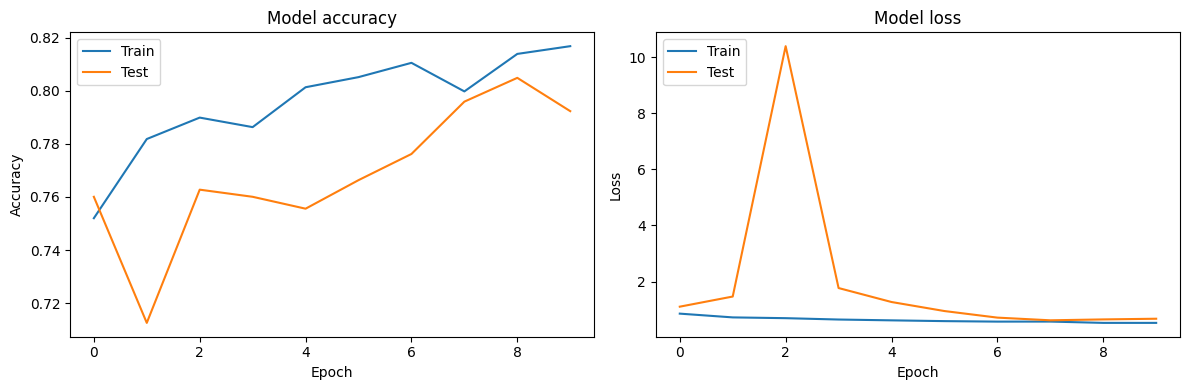

In [39]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
model.save('efficientnet_multiclass_classifier.keras')